# Lecture 3 Practical Solutions

Welcome to the practice session of Lecture 3. During this tutorial, we will use build an image classifier that works on the MNIST Fashion Dataset. The images present in this dataset are 28 x 28 pixels with gray colors. There are 10 categories which you can see in the below table

| Category | CategoryId |
| --- | :---: |
| T-shirt | 0 |
| Trouser | 1 |
| Pullover | 2 |
| Dress | 3 |
| Coat | 4 |
| Sandal | 5 |
| Shirt | 6 |
| Sneaker | 7 |
| Bag | 8 |
| Ankle Boot | 9 |

First, let's install the required libraries

In [1]:
# no need if you are doing in Colab
# !pip install tensorflow keras pandas numpy matplotlib

and import the modules that we will use

In [2]:
# to import and manage data
import pandas as pd
import numpy as np

# to make pretty plots
import matplotlib.pyplot as plt

# to make neural networks
import tensorflow as tf
from tensorflow import keras

In this block, we set the random seed to a specific value to ensure that we get the same results every time

In [3]:
random_seed = 3141

np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## Loading the Data

Since we have our environment set up, we can start working on the problem. 

The MNIST fashion is a famous starter dataset, that's why it can be accessed straight through tensorflow. Add they are already presplit into train and test sets! Checkout the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) to learn more about these datasets.

Let's acquire the features and targets for both the training and test set

In [4]:
# Remember these variables, they will be useful later on
(x_train, y_train), (x_val, y_val) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
id_to_label = {
  0: "T-shirt/top",
  1: "Trouser",
  2: "Pullover",
  3: "Dress",
  4: "Coat",
  5: "Sandal",
  6: "Shirt",
  7: "Sneaker",
  8: "Bag",
  9: "Ankle boot"
}

If we look at the dimensions of the training set, we see that there are 60000 different images. All of these comprise a 28 x 28 2d array 

In [6]:
print(x_train.shape)

(60000, 28, 28)


Let's inspect the image!

<details>
<summary>
Open after you run the next cell
</summary>

AHAH, very readable)))

</details>

In [7]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

Okay, what we can wee is that the values of the iamge are rangin from 0 to 255. To get a better idea of what we are working with, we can display this using [`plt.imshow`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) from matplotlib.

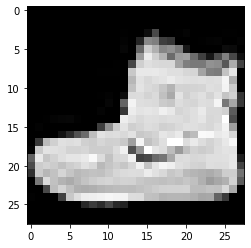

In [8]:
plt.imshow(x_train[0], cmap="gray"); # set cmap (color map) to gray scale

or we can make it even better by plotting first 25 with their names

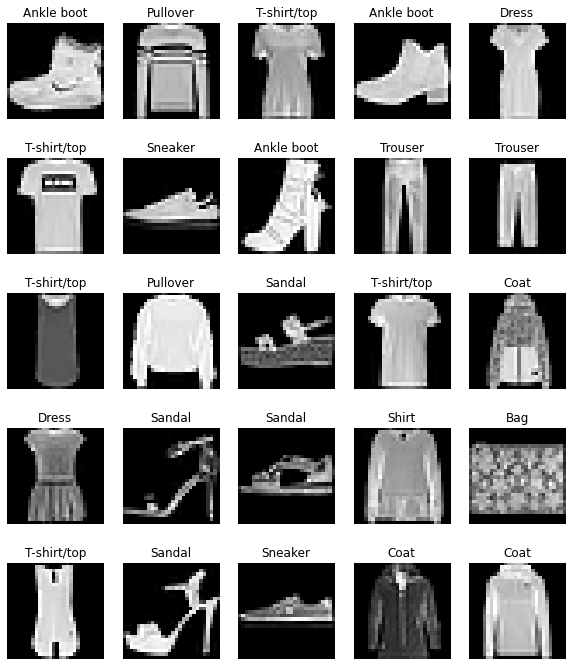

In [9]:
fig, axs = plt.subplots(5, 5, figsize=(10, 12))

for i in range(5):
  for j in range(5):
    idx = i + 5 * j
    image = x_train[idx]
    label_id = y_train[idx]
    label = id_to_label[label_id]

    axs[i][j].imshow(image, cmap="gray") # set cmap (color map) to gray scale
    axs[i][j].set_title(label)           # set the title 
    axs[i][j].axis("off")                # turn off the axis

## Data Pre-processing

Let's define some useful functions for converting the data into a workable form. There are two problems that need to be addressed.
- We need to normalize the scale of the pixels from 0-255 to 0-1
- We need to one hot encode the target values

The pre-process function will be used to normalize the data. It is supposed to take the features and normalize them to the range 0 to 1.

<details>
<summary style="font-size:1.5rem"> Hint </summary>

The range of the data is from 0 to 255. There are no negative values, so we can just divide everything by the maximum value.

<details>
<summary style="font-size:1.5rem"> Answer </summary>

Divide the image by 255

</details>

In [10]:
def preprocess_image(image, target):
  """
  Task 1. scale the image pixel values from range 0-255 to 0-1
  """
  normalized_image = image / 255

  reshaped_image = tf.reshape(normalized_image, [28 * 28])

  return reshaped_image, target

The `create_dataset` function will perform 3 different tasks
- One hot encode the categorical values
- Call preprocess on all images in the training set
- Group the data into batches for faster training

<details>
<summary style="font-size:1.5rem"> Trivia: What are batches?
</summary>

Initially, NN training needed to be done using one item at a time. However, the creation of the GPU allows several processes to be executed parallel to each other. Since the training of a neural network involves a lot of matrix multiplications, GPUs can solve this task excellently. 

A batch is a collection of data points that will be evaluated simultaneously This results in the training of a neural network to complete much faster than it would otherwise. The only limitation of using large batch sizes is that the GPU might not have enough memory.

</details>

Most of `create_dataset` has already been implemented. The only step left is to call preprocess on all images in the dataset. This can actually be implemented in a single line!

<details>
<summary style="font-size:1.5rem"> Hint </summary>

Try to find out how to use [.map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)

<details>
<summary style="font-size:1.5rem"> Answer </summary>

```python
data.map(preprocess_image)
```

</details>

</details>

In [15]:
def create_dataset(xs, ys, n_classes=10):
  ys = tf.one_hot(ys, depth=n_classes)

  data = tf.data.Dataset.from_tensor_slices((xs, ys))

  """
  Task 2. Run the preprocess_image function over all the images in the xs
          This can be done using tensorflow method map on data
  """
  
  processed_data = data.map(preprocess_image)
  
  chunked_data = processed_data.batch(128)

  return chunked_data

Now, that we have created our functions to process the data, we can call them and create our datasets

<details>
<summary style="font-size:1.5rem"> Hint </summary>

Use the `create_dataset` function defined above. What inputs does it take?

<details>
<summary style="font-size:1.5rem"> Answer </summary>

```python
train_dataset = create_dataset(x_train, y_train)
val_dataset = create_dataset(x_val, y_val)
```

</details>

</details>

In [16]:
"""
Task 3. Create the train and validation sets
"""
train_dataset = create_dataset(x_train, y_train)
val_dataset = create_dataset(x_val, y_val)

## Model Creation

Our data is ready for training, let's create our neural network. We can make a 3 layered NN to begin with and see what results we get.

<p align="center">
<img src="https://fully-connected-graph.github.io/GMLM-2022/lecture3/assets/neural_network.png" width="500"><br>
Example of a <a href="https://www.3blue1brown.com/topics/neural-networks">neural network from 3b1b</a> for MNIST digit dataset with 2 hidden layers and 1 output layer
</p>

<details>
<summary style="font-size:1.5rem"> Trivia: What is the softmax activation function?
</summary>

The softmax function is an extension of sigmoid. While sigmoid can only handle binary classifcation, softmax can be used for multiple classes.

<p align="center">
<img src="https://www.nomidl.com/wp-content/uploads/2022/04/image-14.png" alt="drawing" width="600"/>
</p>

</details>

Add three hidden layers in between the input and output layer with 64 neurons each. A good activation function that we can use would be ReLu.

<details>
<summary style="font-size:1.5rem"> Hint </summary>

You can look at how we created layers in the titanic example. The activation function for ReLu is simply "relu"

<details>
<summary style="font-size:1.5rem"> Answer </summary>

keras.layers.Dense(units=64, activation='relu')

</details>

</details>

In [17]:
"""
  Task 4. Add 4 hidden layers with 64 neurons each.
          You can use the Dense function from the keras library
"""

model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(28 * 28)),    # input layer
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=10, activation='softmax') # output layer
])

We can now compile our model. We will use the categorical crossentropy loss function since our target values are categorical.

We also need to decide on a metric to judge our model

<details>
<summary style="font-size:1.5rem"> Hint </summary>

For categorical targets, we can check whether the predicted value is the same as the actual value

<details>
<summary style="font-size:1.5rem"> Answer </summary>

Use accuracy

</details>

</details>

In [18]:
"""
  Task 5. Decide on a metric to train the model with.
"""
model.compile(optimizer='adam', 
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=['accuracy']) # Pass the metric as an argument

Our model is ready for training! We can fit our model on the training data and let it run for some time.

<details>
<summary style="font-size:1.5rem"> Trivia: What are epochs?
</summary>

Neural networks can gain better performance when we rerun the model on the same dataset several times. Each training session is known as an epoch. We need to make sure to not use a high number of epochs as this might lead to overfitting.

</details>

In [19]:
history = model.fit(
    train_dataset.repeat(), 
    epochs=10, 
    steps_per_epoch=500,
)

Epoch 1/10
500/500 [==============================] - 4s 7ms/step - loss: 0.5803 - accuracy: 0.7975
Epoch 2/10
500/500 [==============================] - 4s 7ms/step - loss: 0.3969 - accuracy: 0.8584
Epoch 3/10
500/500 [==============================] - 3s 7ms/step - loss: 0.3606 - accuracy: 0.8704
Epoch 4/10
500/500 [==============================] - 3s 7ms/step - loss: 0.3351 - accuracy: 0.8776
Epoch 5/10
500/500 [==============================] - 3s 7ms/step - loss: 0.3193 - accuracy: 0.8832
Epoch 6/10
500/500 [==============================] - 3s 7ms/step - loss: 0.3044 - accuracy: 0.8888
Epoch 7/10
500/500 [==============================] - 3s 7ms/step - loss: 0.2912 - accuracy: 0.8926
Epoch 8/10
500/500 [==============================] - 3s 7ms/step - loss: 0.2811 - accuracy: 0.8968
Epoch 9/10
500/500 [==============================] - 4s 7ms/step - loss: 0.2702 - accuracy: 0.9002
Epoch 10/10
500/500 [==============================] - 3s 7ms/step - loss: 0.2629 - accuracy: 0.9033

Our model appears to have a high accuracy on the training set. But how will it fare on unseen data. Let's find out!

Evaluate the model on unseen data. This can be done in one line

<details>
<summary style="font-size:1.5rem"> Hint </summary>

The evaluate method of the model can be used to evaluate test date. Check the documentation at [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

<details>
<summary style="font-size:1.5rem"> Answer </summary>

print(model.evaluate(val_dataset))

</details>

</details>

In [20]:
"""
  Task 6. Evaluate the model on the validation set
"""
print(model.evaluate(val_dataset))

79/79 [==============================] - 1s 6ms/step - loss: 0.3796 - accuracy: 0.8644
[0.3795928359031677, 0.8644000291824341]


To determine if our model would be useful, we can compare it to a dummy model. However, since we are dealing with categorical data, we can actually look at the most frequent element and compare it to the total population. This would give us the accuracy of the dummy model.

In [21]:
print(np.bincount(y_train))

[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


Each clothing item appears equally. Thus, the accuracy of a dummy model would be 10% (6000 / 60000). This means that our model actually does something!

## Manual Check

Perhaps you want to check an image manually and see if the model predicts it. In this case, you can run the below code

In [ ]:
predictions = model.predict(val_dataset)

79/79 [==============================] - 1s 6ms/step


T-shirt/top


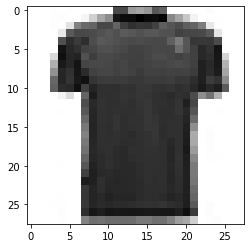

In [ ]:
print(id_to_label[np.argmax(predictions[random_seed])])
plt.imshow(x_val[random_seed], cmap=plt.cm.binary)

## Conclusion

Congratulations on reaching the end of this practical and making your own image classifier. If you wish to attain state of the art performance on image classification problems, then we suggest that you look at more modern techniques such as [Convolutional Neural Networks](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)